<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/tpu_multilabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics

In [2]:
!wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

--2021-06-17 15:03:25--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘CheXpert-v1.0-small.zip’

CheXpert-v1.0-small 100%[===================>]  10.76G  5.15MB/s    in 36m 43s 

2021-06-17 15:40:08 (5.00 MB/s) - ‘CheXpert-v1.0-small.zip’ saved [11557753157/11557753157]



In [3]:
%%capture
!unzip /content/CheXpert-v1.0-small.zip

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
train=pd.read_csv('/content/CheXpert-v1.0-small/train.csv')
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
val=pd.read_csv('/content/CheXpert-v1.0-small/valid.csv')
val.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
image_names = []
labels = []
import csv
def read_images(path):
  policy='ones'
  with open(path, "r") as f:
      csvReader = csv.reader(f)
      next(csvReader, None)
      k=0
      for line in csvReader:
          k+=1
          image_name= line[0]
          label = line[5:]
          
          for i in range(14):
              if label[i]:
                  a = float(label[i])
                  if a == 1:
                      label[i] = 1
                  elif a == -1:
                      if policy == "ones":
                          label[i] = 1
                      elif policy == "zeroes":
                          label[i] = 0
                      else:
                          label[i] = 0
                  else:
                      label[i] = 0
              else:
                  label[i] = 0
                  
          image_names.append(image_name)
          labels.append(label)
  return image_names,labels

In [8]:
train_image,train_label=read_images('/content/CheXpert-v1.0-small/train.csv')
val_image,val_label=read_images('/content/CheXpert-v1.0-small/valid.csv')

In [9]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
print(len(class_names))

14


In [10]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight

In [31]:
aug=transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [54]:
from PIL import Image
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,image,label,transform=None):
    super(DataReader,self).__init__()
    self.image=image
    self.label=label
    self.transform=transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image_path=self.image[index]
    image_label=self.label[index]

    #read data
    image=Image.open(image_path).convert('L')

    if self.transform:
      image=self.transform(image)

    return image,torch.tensor(image_label,dtype=torch.float32)

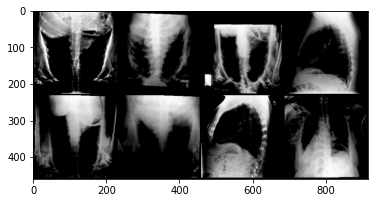

In [55]:
#code testing
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
train=DataReader(np.array(train_image),np.array(train_label),transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=8)
batch,_=next(iter(train_loader))
grid_img=torchvision.utils.make_grid(batch,4,4)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

In [84]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
from torch import Tensor
from typing import Any, List, Tuple




class _DenseLayer(nn.Module):
    def __init__(
        self,
        num_input_features: int,
        growth_rate: int,
        bn_size: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseLayer, self).__init__()
        self.norm1: nn.BatchNorm2d
        self.add_module('norm1', nn.BatchNorm2d(num_input_features))
        self.relu1: nn.ReLU
        self.add_module('relu1', nn.ReLU(inplace=True))
        self.conv1: nn.Conv2d
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))
        self.norm2: nn.BatchNorm2d
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
        self.relu2: nn.ReLU
        self.add_module('relu2', nn.ReLU(inplace=True))
        self.conv2: nn.Conv2d
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False
    ) -> None:
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config: Tuple[int, int, int, int] = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False
    ) -> None:

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(1, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)
        self.classifier1 = nn.Linear(num_classes, 14)
        self.classifier2=nn.Sigmoid()


        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        out = self.classifier1(out)
        out = self.classifier2(out)
        
        return out





def _densenet(
    arch: str,
    growth_rate: int,
    block_config: Tuple[int, int, int, int],
    num_init_features: int,
   
    **kwargs: Any
) -> DenseNet:
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    return model


def densenet121( **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64,
                     **kwargs)

In [85]:
x=torch.randn(1,1,224,224)
model=densenet121()
out=model(x)
out.shape

torch.Size([1, 14])

In [58]:
# criterion=nn.BCEWithLogitsLoss()
# criterion(out,torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32))

In [59]:
# pred=torch.tensor(np.expand_dims(train_label[0],0),dtype=torch.float32)
# pred.shape,out.shape


In [88]:
import torch.nn as nn
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = densenet121()
   
    
    
  #parameters
    self.batch_size=64
    self.numworker=1
    self.criterion=nn.BCELoss()
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    return torch.optim.Adam(params=self.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0)

  def train_dataloader(self):
    return DataLoader(DataReader(np.array(train_image),np.array(train_label),aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(np.array(val_image),np.array(val_label),aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    self.log('vall/loss', loss, on_epoch=True,prog_bar=True)
    return loss

In [ ]:
early_stop_callback = EarlyStopping(monitor='vall/loss', min_delta=0.00, patience=2, verbose=True, mode='min')
model = OurModel()
trainer = Trainer(max_epochs=10, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[early_stop_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores

  | Name      | Type     | Params
---------------------------------------
0 | layer     | DenseNet | 8.0 M 
1 | criterion | BCELoss  | 0     
---------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
15.973    Total estimated model params size (MB)


[rank: 1] Metric vall/loss improved. New best score: 0.407
[rank: 0] Metric vall/loss improved. New best score: 0.402
[rank: 3] Metric vall/loss improved. New best score: 0.409
[rank: 6] Metric vall/loss improved. New best score: 0.401
[rank: 7] Metric vall/loss improved. New best score: 0.413
[rank: 5] Metric vall/loss improved. New best score: 0.405
[rank: 2] Metric vall/loss improved. New best score: 0.409
[rank: 4] Metric vall/loss improved. New best score: 0.404


[rank: 5] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.405
[rank: 4] Metric vall/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.398
[rank: 2] Metric vall/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.399
[rank: 7] Metric vall/loss improved by 0.013 >= min_delta = 0.0. New best score: 0.400
[rank: 6] Metric vall/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.397
[rank: 3] Metric vall/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.404
[rank: 1] Metric vall/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.399


[rank: 3] Metric vall/loss improved by 0.009 >= min_delta = 0.0. New best score: 0.395
[rank: 5] Metric vall/loss improved by 0.011 >= min_delta = 0.0. New best score: 0.394
[rank: 4] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.394
[rank: 2] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.394
[rank: 0] Metric vall/loss improved by 0.010 >= min_delta = 0.0. New best score: 0.392
[rank: 7] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.395
[rank: 6] Metric vall/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.390


[rank: 5] Metric vall/loss improved by 0.002 >= min_delta = 0.0. New best score: 0.392
[rank: 1] Metric vall/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.391
[rank: 4] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.389
[rank: 2] Metric vall/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.390
[rank: 3] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.390


[rank: 0] Metric vall/loss improved by 0.004 >= min_delta = 0.0. New best score: 0.388
[rank: 6] Metric vall/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.387
[rank: 7] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.390
[rank: 2] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.390
[rank: 5] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.387


[rank: 7] Metric vall/loss improved by 0.007 >= min_delta = 0.0. New best score: 0.383
[rank: 4] Metric vall/loss improved by 0.006 >= min_delta = 0.0. New best score: 0.383
[rank: 3] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.384
[rank: 1] Metric vall/loss improved by 0.008 >= min_delta = 0.0. New best score: 0.383
[rank: 6] Metric vall/loss improved by 0.000 >= min_delta = 0.0. New best score: 0.387
[rank: 5] Metric vall/loss improved by 0.003 >= min_delta = 0.0. New best score: 0.385
[rank: 2] Metric vall/loss improved by 0.005 >= min_delta = 0.0. New best score: 0.385
